## Model Explainability

<hr />

## Environment

In [1]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
import pickle

from model_analysis import get_sens_spec, scan_thresold, get_threshold_for_sens

# print the JS visualization code to the notebook
shap.initjs()

## Load Models and Data


In [2]:
# Import dataset
train_X = pd.read_csv('../extraction/data/train_X.csv').set_index('patientunitstayid')
train_y = pd.read_csv('../extraction/data/train_y.csv')

test_X = pd.read_csv('../extraction/data/test_X.csv').set_index('patientunitstayid')
test_y = pd.read_csv('../extraction/data/test_y.csv')

X = pd.concat([train_X,test_X], axis=0,ignore_index=True)
y = pd.concat([train_y,test_y], axis=0,ignore_index=True)

In [4]:
# Import model
xgb_full = pickle.load(open('./xgb_full', 'rb'))

In [5]:
# Model predictions for test set
threshold = get_threshold_for_sens(xgb_full.predict_proba(test_X)[:,1],test_y,0.945)
test_y_pred = pd.DataFrame(xgb_full.predict_proba(test_X)[:,1]>threshold).astype(int)
# Rename columns
test_y_pred.columns = ['pred_hospital_expiration']

## Conventional Feature Importance

Text(0.5, 1.0, 'xgboost.plot_importance(model)')

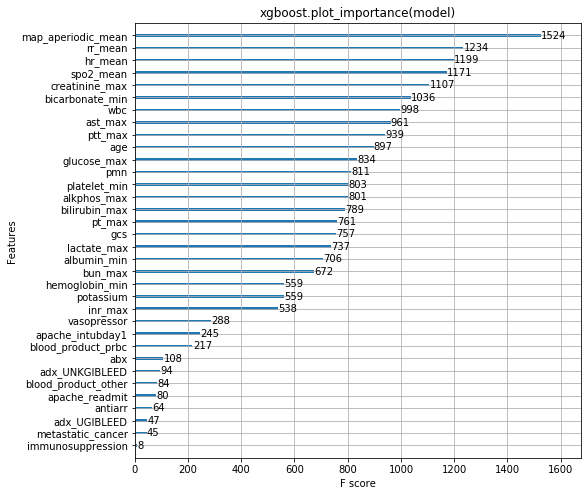

In [6]:
fig, ax = plt.subplots(figsize=(8,8))
xgboost.plot_importance(xgb_full, ax=ax)
ax.set_title('xgboost.plot_importance(model)')

Text(0.5, 1.0, 'xgboost.plot_importance(model, importance_type="cover")')

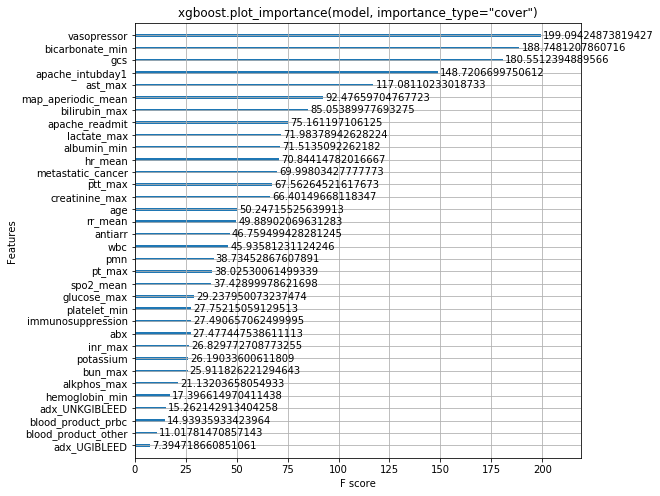

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
xgboost.plot_importance(xgb_full, importance_type="cover", ax=ax)
ax.set_title('xgboost.plot_importance(model, importance_type="cover")')

Text(0.5, 1.0, 'xgboost.plot_importance(model, importance_type="gain")')

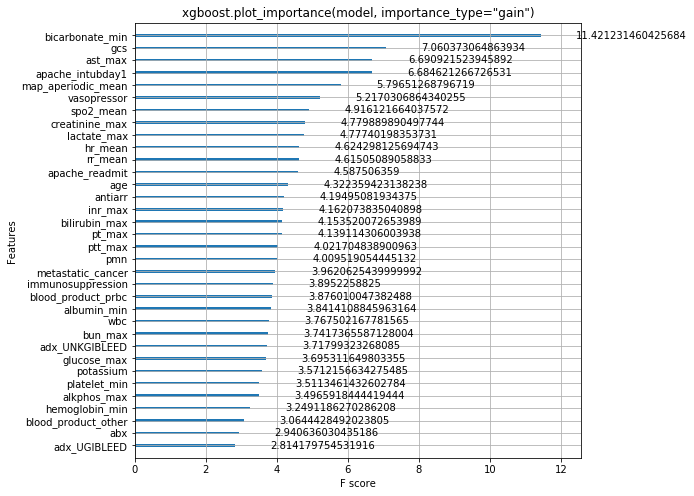

In [8]:
fig, ax = plt.subplots(figsize=(8,8))
xgboost.plot_importance(xgb_full, importance_type="gain", ax=ax)
ax.set_title('xgboost.plot_importance(model, importance_type="gain")')

## SHAP Base Explainability

In [9]:
# SHAP Explainer
explainer = shap.TreeExplainer(xgb_full)
shap_values = explainer.shap_values(test_X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Vizualize single prediction

In [10]:
# Find all indexes where patient expired and model predicted accurately
indx_exp_acc = list(test_y[(test_y['hospital_expiration'] == 1) & (test_y_pred['pred_hospital_expiration'] == 1)].index)
# Find all indexes where patient expired and model misclassified
indx_exp_mc = list(test_y[(test_y['hospital_expiration'] == 1) & (test_y_pred['pred_hospital_expiration'] == 0)].index)
# Find all indexes where patient lived and model predicted accurately
indx_alive_acc = list(test_y[(test_y['hospital_expiration'] == 0) & (test_y_pred['pred_hospital_expiration'] == 0)].index)
# Find all indexes where patient lived and model misclassified
indx_alive_mc = list(test_y[(test_y['hospital_expiration'] == 0) & (test_y_pred['pred_hospital_expiration'] == 1)].index)

In [11]:
def get_random_patient(indx_patients, n=1):
    # Pick a random index
    try:
        indx = indx_patients[np.random.randint(0,len(indx_patients),n)[0]]
    except ValueError:
        indx = -1
    return indx

In [12]:
# Get random index
i1 = get_random_patient(indx_exp_acc)
i2 = get_random_patient(indx_exp_acc)
i3 = get_random_patient(indx_alive_acc)
i4 = get_random_patient(indx_alive_acc)
i5 = get_random_patient(indx_exp_mc)
i6 = get_random_patient(indx_alive_mc)
print('Selected index (Expired, Predicted Accurately): {}, {}'.format(i1,i2))
print('Selected index (Alive, Predicted Accurately): {}, {}'.format(i3,i4))
print('Selected index (Expired, Misclassified): {}'.format(i5))
print('Selected index (Alive, Misclassified: {}'.format(i6))

Selected index (Expired, Predicted Accurately): 28, 704
Selected index (Alive, Predicted Accurately): 166, 861
Selected index (Expired, Misclassified): 462
Selected index (Alive, Misclassified: 692


In [14]:
indx_to_explain = [i1,i2,i3,i4,i5,i6]
# Get patient feature
test_X.iloc[indx_to_explain]

,age,metastatic_cancer,immunosuppression,apache_readmit,apache_intubday1,hr_mean,map_aperiodic_mean,rr_mean,spo2_mean,albumin_min,bicarbonate_min,bun_max,bilirubin_max,creatinine_max,glucose_max,hemoglobin_min,lactate_max,platelet_min,ptt_max,inr_max,pt_max,ast_max,alkphos_max,abx,vasopressor,antiarr,blood_product_prbc,blood_product_other,potassium,wbc,pmn,adx_UGIBLEED,adx_UNKGIBLEED,gcs
patientunitstayid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
964737,87.0,0,0,0,0,73.280632,58.206186,19.705179,98.898785,2.0,22.6,24.0,0.3,1.06,189.0,7.1,NaN,103.0,27.4,1.0,11.1,15.0,49.0,0.0,0.0,0.0,0.0,1.0,3.8,8.20,72.2,0,1,15.0
2780340,52.0,0,0,0,0,106.169355,86.833333,15.911290,99.588710,2.0,24.0,38.0,9.4,0.59,390.0,8.3,NaN,119.0,35.4,1.2,15.2,135.0,288.0,1.0,0.0,0.0,1.0,0.0,4.3,8.00,71.0,1,0,15.0
393141,58.0,0,1,0,0,99.141221,69.756410,21.091603,99.669355,3.1,19.5,21.0,0.4,0.80,116.0,6.7,NaN,350.0,NaN,1.1,11.6,16.0,48.0,0.0,0.0,0.0,1.0,0.0,4.9,6.80,68.5,1,0,15.0
527963,58.0,0,0,0,0,70.273063,71.666667,14.759336,99.127119,3.3,25.0,12.0,0.4,0.50,90.0,5.8,NaN,472.0,26.9,1.0,12.6,32.0,51.0,0.0,0.0,0.0,0.0,1.0,4.1,9.80,NaN,0,1,15.0
2587564,63.0,0,1,0,0,83.829457,80.815789,16.744186,99.232558,2.7,18.0,70.0,1.1,1.10,159.0,4.7,NaN,101.0,29.0,1.2,15.6,46.0,228.0,1.0,0.0,0.0,1.0,0.0,4.2,5.18,75.0,1,0,15.0
1571876,76.0,0,0,0,0,83.522807,66.945455,14.143860,96.161404,2.5,28.0,23.0,0.8,1.43,114.0,7.9,NaN,33.0,NaN,1.3,16.1,26.0,67.0,0.0,0.0,0.0,1.0,0.0,4.4,7.11,74.5,1,0,14.0


In [15]:
# Feature names
feat_names = ['Age','Metastatic Cancer', 'Immunosuppression',
              'Readmit', 'Intubation', 'HR',
       'MAP', 'RR', 'SPO2', 'Albumin',
       'Bicarbonate', 'BUN', 'Bilirubin', 'Creatinine',
       'Glucose', 'Hemoglobin', 'Lactate', 'Platelet',
       'PTT', 'INR', 'PT', 'AST', 'AlkPhos', 'Abx',
       'Vasopressor', 'Antiarr', 'BP-PRBC', 'BP-Other',
       'Potassium', 'WBC', 'PMN', 
       'UGIB', 'UNKGIB', 'GCS']

In [16]:
# Patient 1 (Expired, Predicted Accurately)
indx = indx_to_explain[0]
shap.force_plot(explainer.expected_value, shap_values[indx,:], test_X.round(2).iloc[indx,:],link='logit',feature_names=feat_names,figsize=(20,6), text_rotation=20)

In [17]:
# Patient 2 (Expired, Predicted Accurately)
indx = indx_to_explain[1]
shap.force_plot(explainer.expected_value, shap_values[indx,:], test_X.round(2).iloc[indx,:],link='logit',feature_names=feat_names,figsize=(20,6), text_rotation=20)

In [18]:
# Patient 3 (Alive, Predicted Accurately)
indx = indx_to_explain[2]
shap.force_plot(explainer.expected_value, shap_values[indx,:], test_X.round(2).iloc[indx,:],link='logit',feature_names=feat_names,figsize=(20,6), text_rotation=20)

In [19]:
# Patient 4 (Alive, Predicted Accurately)
indx = indx_to_explain[3]
shap.force_plot(explainer.expected_value, shap_values[indx,:], test_X.round(2).iloc[indx,:],link='logit',feature_names=feat_names,figsize=(20,6), text_rotation=20)

In [20]:
# Patient 5 (Expired, Misclassified)
indx = indx_to_explain[4]
shap.force_plot(explainer.expected_value, shap_values[indx,:], test_X.round(2).iloc[indx,:],link='logit',feature_names=feat_names,figsize=(20,6), text_rotation=20)

In [21]:
# Patient 6 (Alive, Misclassified)
indx = indx_to_explain[5]
shap.force_plot(explainer.expected_value, shap_values[indx,:], test_X.round(2).iloc[indx,:],link='logit',feature_names=feat_names,figsize=(20,6), text_rotation=20)

### Vizualize many predictions

In [22]:
shap.force_plot(explainer.expected_value, shap_values[indx_to_explain,:], test_X.iloc[indx_to_explain,:])

### Bar chart of mean importance

In [23]:
feat_names = ['Age', 'Metastatic Cancer', 'Immunosuppression',
              'Readmit', 'Intubation', 'HR (mean)',
       'MAP (mean)', 'RR (mean)', 'SPO2 (mean)', 'Albumin (min)',
       'Bicarbonate (min)', 'BUN (max)', 'Bilirubin (max)', 'Creatinine (max)',
       'Glucose (max)', 'Hemoglobin (min)', 'Lactate (max)', 'Platelet (min)',
       'PTT (max)', 'INR (max)', 'PT (max)', 'AST (max)', 'AlkPhos (max)', 'Abx',
       'Vasopressor', 'Antiarr', 'BP-PRBC', 'BP-Other',
       'Potassium', 'WBC', 'PMN',
       'UGIB', 'UNKGIB', 'GCS']

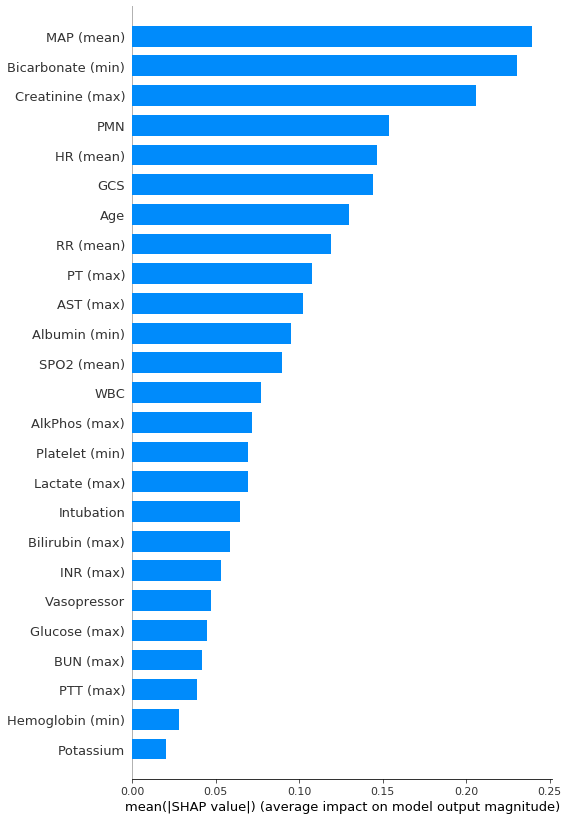

In [24]:
shap.summary_plot(shap_values, test_X, plot_type="bar",show=False,max_display=25, feature_names=feat_names)
plt.tight_layout()
plt.savefig('shap_summary.jpg')

### SHAP Summary Plot

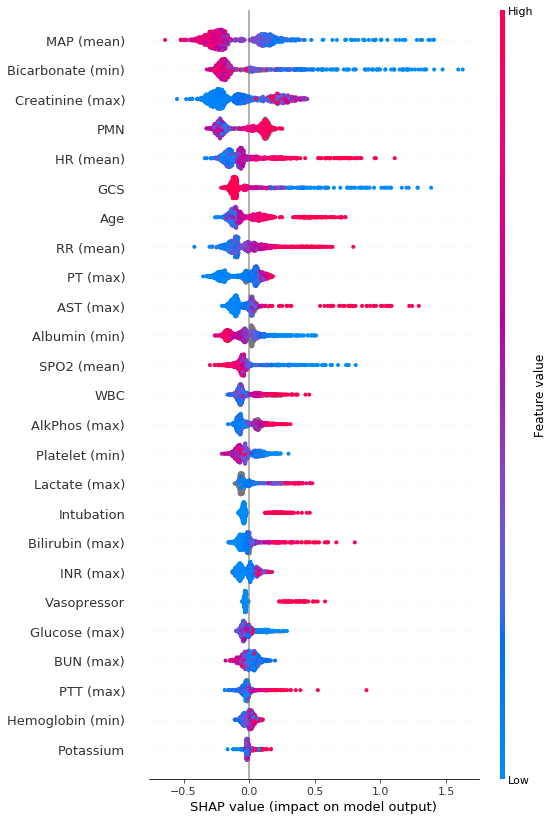

In [25]:
shap.summary_plot(shap_values, test_X, show = False, max_display=25, feature_names=feat_names)
plt.tight_layout()
plt.savefig('shap_summary_2.jpg')